# Term Paper QAOA Demo — Max-Cut (6-node 3-regular graph)
**Author:** Advaith Srinath  
**Frameworks:** Qiskit & PennyLane  
**Purpose:** Demonstrate a small QAOA run (p=1) with Nelder–Mead optimizer, show expectation vs iterations and sample histograms, and compare with classical brute-force/MaxSAT optimum.


## What we'll do (step-by-step)
1) Setup imports and environment
2) Build a random 3-regular graph and visualize it
3) Compute the classical Max-Cut optimum (RC2 MaxSAT if available, else brute force)
4) QAOA with Qiskit (build circuit, estimate expectation, optimize, sample)
5) QAOA with PennyLane (expectation QNode, optimize, sample)


In [1]:
# (Optional) Install dependencies if needed
# import sys
# !{sys.executable} -m pip install qiskit qiskit-aer pennylane python-sat networkx numpy scipy matplotlib

## 1) Setup imports and environment
Seed randomness for reproducibility and import libraries for Qiskit, PennyLane, plotting, and optimization.

In [2]:
import math
import random
from itertools import product
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

# PennyLane
import pennylane as qml
from pennylane import numpy as pnp

# Optional: PySAT RC2 (MaxSAT)
try:
    from pysat.formula import WCNF
    from pysat.examples.rc2 import RC2
    HAS_PYSAT = True
except Exception:
    HAS_PYSAT = False

plt.rcParams['figure.figsize'] = (7, 4)
np.random.seed(42)
random.seed(42)

## 2) Build a random 3-regular graph and visualize it
We create a small 3-regular graph (n=6) and draw it. This will be the Max-Cut instance.

Graph edges: [(0, 1), (0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (2, 5), (3, 4), (3, 5)]


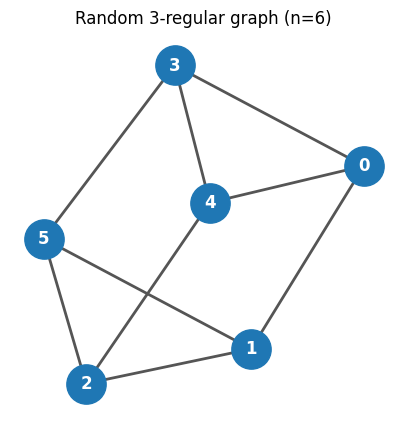

In [3]:
def random_3_regular_graph(n, seed=None):
    return nx.random_regular_graph(3, n, seed=seed)

def draw_graph(G, seed=None, figsize=(5, 5), title=None):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx(
        G, pos=pos, with_labels=True, node_color="#1f77b4", node_size=800,
        font_color="white", font_weight="bold", edge_color="#555", width=2,
    )
    if title is None:
        title = f"Random 3-regular graph (n={G.number_of_nodes()})"
    plt.title(title)
    plt.axis("off")
    plt.show()

n = 6
seed = 42
G = random_3_regular_graph(n, seed=seed)
print("Graph edges:", sorted(G.edges()))
draw_graph(G, seed=42)

## 3) Classical Max-Cut optimum (RC2 MaxSAT if available, else brute force)
We first compute the classical optimum to benchmark QAOA later.

### What this cell does — Exact Max-Cut via MaxSAT (PySAT/RC2)
- Replaces brute-force Max-Cut with an exact solver using the PySAT RC2 MaxSAT algorithm when available.
- Reduces Max-Cut to a weighted Max-2SAT instance:
  - For each edge (i, j), add two soft clauses (weight = 1 each):
    - (x_i ∨ x_j)
    - (¬x_i ∨ ¬x_j)
  - Exactly one of these is always satisfied; both are satisfied if and only if x_i ≠ x_j (i.e., the edge is cut).
  - The number of satisfied clauses equals |E| + cut_size.

If `python-sat` is unavailable, we fall back to brute force for small graphs.

In [4]:
def maxcut_value(bitstr, G):
    return sum(1 for i, j in G.edges() if bitstr[i] != bitstr[j])

def brute_force_maxcut(G):
    n = G.number_of_nodes()
    best, best_bs = -1, None
    for bits in product([0, 1], repeat=n):
        val = maxcut_value(bits, G)
        if val > best:
            best, best_bs = val, bits
    return best, best_bs

def classical_maxcut(G):
    if not HAS_PYSAT:
        return brute_force_maxcut(G)
    n = G.number_of_nodes()
    wcnf = WCNF()
    for i, j in G.edges():
        a, b = i + 1, j + 1
        wcnf.append([a, b], weight=1)
        wcnf.append([-a, -b], weight=1)
    with RC2(wcnf) as rc2:
        model = rc2.compute()
    mset = set(model)
    assign = tuple(1 if (k + 1) in mset else 0 for k in range(n))
    return maxcut_value(assign, G), assign

opt_val, opt_bs = classical_maxcut(G)
print(f"Classical optimum cut: {opt_val}, assignment: {opt_bs}")

Classical optimum cut: 7, assignment: (0, 1, 0, 1, 1, 0)


## 4) QAOA with Qiskit — Build circuit for p=1
We now implement a single-layer QAOA circuit in Qiskit.
- Initialize |+>^n
- Apply problem unitary via CNOT-RZ-CNOT per edge
- Apply RX(2β) mixer per qubit
- We'll first build a circuit for given (γ, β), then estimate the expected cut.

In [5]:
def qaoa_circuit_qiskit(G, p, gammas, betas):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n)
    # |+>^n
    for q in range(n):
        qc.h(q)
    # p layers
    for layer in range(p):
        gamma = float(gammas[layer])
        beta = float(betas[layer])
        for i, j in G.edges():
            qc.cx(i, j)
            qc.rz(2 * gamma, j)
            qc.cx(i, j)
        for q in range(n):
            qc.rx(2 * beta, q)
    qc.measure_all()
    return qc

# Quick sanity: build with random params
p = 1
test_params = np.random.uniform(0, math.pi, size=2 * p)
qc_test = qaoa_circuit_qiskit(G, p, test_params[:p], test_params[p:])
print(qc_test.draw(fold=120))

        ┌───┐                                                                                                         »
   q_0: ┤ H ├──■──────────────────■────■────────────────────────────────■─────────■───────────────────────────────────»
        ├───┤┌─┴─┐┌────────────┐┌─┴─┐  │                                │         │                                   »
   q_1: ┤ H ├┤ X ├┤ Rz(2.3533) ├┤ X ├──┼────────■───────────────────────┼────■────┼────■──────────────────────────────»
        ├───┤└───┘└────────────┘└───┘  │      ┌─┴─┐     ┌────────────┐  │  ┌─┴─┐  │    │                              »
   q_2: ┤ H ├──────────────────────────┼──────┤ X ├─────┤ Rz(2.3533) ├──┼──┤ X ├──┼────┼────────■─────────────────────»
        ├───┤                          │      └───┘     └────────────┘  │  └───┘┌─┴─┐  │        │       ┌────────────┐»
   q_3: ┤ H ├──────────────────────────┼────────────────────────────────┼───────┤ X ├──┼────────┼───────┤ Rz(2.3533) ├»
        ├───┤                        ┌─┴

### Estimate expected cut (statevector or sampling)
We'll write a small helper to compute the expected cut value for given parameters using statevector (exact) or sampling (noisy). For the demo, we use statevector to speed up optimization.

In [6]:
def estimate_expectation_qiskit(qc, G, shots=2000, use_statevector=True):
    n = G.number_of_nodes()
    if use_statevector:
        qc_nomeas = qc.remove_final_measurements(inplace=False)
        sv = Statevector.from_instruction(qc_nomeas)
        amps = sv.data
        exp = 0.0
        for idx, amp in enumerate(amps):
            prob = abs(amp) ** 2
            bits = tuple(((idx >> k) & 1) for k in range(n))  # q0 is LSB
            exp += prob * maxcut_value(bits, G)
        return exp
    else:
        sim = AerSimulator()
        tqc = transpile(qc, sim)
        result = sim.run(tqc, shots=shots).result()
        counts = result.get_counts(tqc)
        exp = 0.0
        for bitstr, cnt in counts.items():
            bits = tuple(int(b) for b in bitstr[::-1])
            exp += (cnt / shots) * maxcut_value(bits, G)
        return exp

# Test expectation for the random test params
exp_test = estimate_expectation_qiskit(qc_test, G, use_statevector=True)
print("Test expected cut:", exp_test)

Test expected cut: 5.351231519068926


### Optimize (γ, β) by Nelder–Mead
We now define an objective (negative expected cut) and optimize. We'll log expectation values per iteration and plot the progress.

Optimization terminated successfully.
         Current function value: -5.939222
         Iterations: 34
         Function evaluations: 70
Qiskit best expected cut: 5.93922244550181
Qiskit best params (gamma,beta): [2.85641185] [1.91894166]


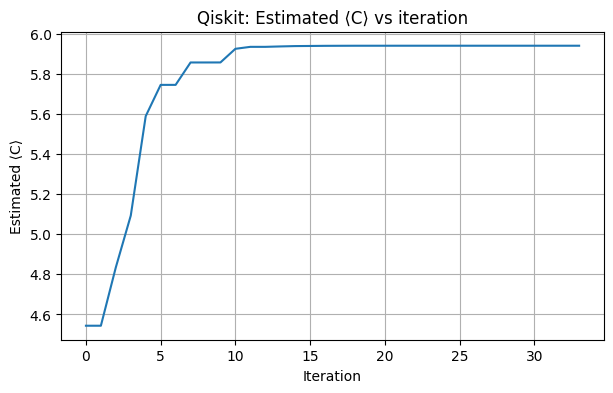

In [7]:
def qaoa_obj_qiskit(params, G, p, shots, use_statevector):
    gammas = params[:p]
    betas = params[p : 2 * p]
    circuit = qaoa_circuit_qiskit(G, p, gammas, betas)
    return -estimate_expectation_qiskit(circuit, G, shots=shots, use_statevector=use_statevector)

q_hist = []
def q_cb(xk):
    val = -qaoa_obj_qiskit(xk, G, p=1, shots=2000, use_statevector=True)
    q_hist.append(val)

x0 = np.random.uniform(0, math.pi, size=2 * p)
res_q = minimize(
    fun=lambda x: qaoa_obj_qiskit(x, G, p=1, shots=2000, use_statevector=True),
    x0=x0, method='Nelder-Mead', options={'maxiter': 80, 'disp': True, 'fatol': 1e-3}, callback=q_cb
)
params_q = res_q.x
best_exp_q = -res_q.fun
print("Qiskit best expected cut:", best_exp_q)
print("Qiskit best params (gamma,beta):", params_q[:1], params_q[1:])

plt.figure()
plt.plot(q_hist)
plt.title("Qiskit: Estimated ⟨C⟩ vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Estimated ⟨C⟩")
plt.grid(True)
plt.show()

### Sample from the optimized QAOA circuit and show top bitstrings
We now take the best (γ, β), run the circuit with a sampler, and show the most frequent bitstrings with their cut values.

Top 5 Qiskit sampled bitstrings (bits, count, cut):
((0, 1, 1, 1, 0, 0), 142, 7)
((1, 0, 0, 0, 1, 1), 141, 7)
((0, 1, 0, 0, 1, 1), 136, 7)
((0, 1, 0, 1, 1, 0), 135, 7)
((1, 0, 1, 1, 0, 0), 128, 7)


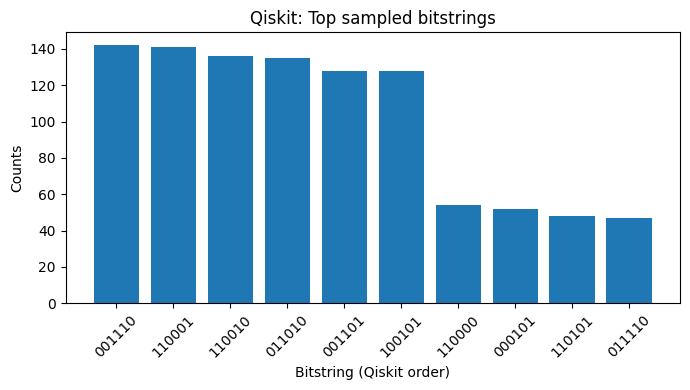

In [8]:
def qiskit_sample_and_top_counts(qc, G, shots=2000, top_k=10):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts(tqc)
    items = []
    for bitstr, cnt in counts.items():
        bits = tuple(int(b) for b in bitstr[::-1])
        items.append((bits, cnt, maxcut_value(bits, G)))
    return sorted(items, key=lambda x: x[1], reverse=True)

qc_best = qaoa_circuit_qiskit(G, 1, params_q[:1], params_q[1:])
items_q = qiskit_sample_and_top_counts(qc_best, G, shots=2000, top_k=10)
print("Top 5 Qiskit sampled bitstrings (bits, count, cut):")
for row in items_q[:5]:
    print(row)

labels = [''.join(map(str, b[::-1])) for b,_,_ in items_q[:10]]
values = [cnt for _,cnt,_ in items_q[:10]]
plt.figure()
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45)
plt.title("Qiskit: Top sampled bitstrings")
plt.xlabel("Bitstring (Qiskit order)")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

## 5) QAOA with PennyLane — Expectation QNode (p=1)
We implement the same layer in PennyLane. We'll use an expectation-based QNode for fast optimization, then sample.

In [9]:
def pl_apply_u_c(gamma, G):
    for i, j in G.edges():
        qml.CNOT(wires=[i, j])
        qml.RZ(2 * gamma, wires=j)
        qml.CNOT(wires=[i, j])

def pl_apply_u_b(beta, n):
    for i in range(n):
        qml.RX(2 * beta, wires=i)

def make_pl_expectation_qnode(G, p=1):
    n = G.number_of_nodes()
    dev = qml.device('default.qubit', wires=n)
    @qml.qnode(dev, interface='autograd')
    def qnode(gammas, betas):
        for i in range(n):
            qml.Hadamard(wires=i)
        for layer in range(p):
            pl_apply_u_c(gammas[layer], G)
            pl_apply_u_b(betas[layer], n)
        return [qml.expval(qml.PauliZ(wires=i) @ qml.PauliZ(wires=j)) for i, j in G.edges()]
    def expval(gammas, betas):
        zz = qnode(gammas, betas)
        m = len(G.edges())
        return 0.5 * (m - pnp.sum(zz))
    return expval

expval_pl = make_pl_expectation_qnode(G, p=1)
test_params_pl = np.random.uniform(0, math.pi, size=2)
print("Test PL expected cut:", float(expval_pl(test_params_pl[:1], test_params_pl[1:])))

Test PL expected cut: 3.6452999035818006


### Optimize (γ, β) with Nelder–Mead in PennyLane
We minimize the negative expectation and log progress to plot convergence.

Optimization terminated successfully.
         Current function value: -5.939222
         Iterations: 24
         Function evaluations: 48
PennyLane best expected cut: 5.939222446192684
PennyLane best params (gamma,beta): [2.85643731] [1.91901841]


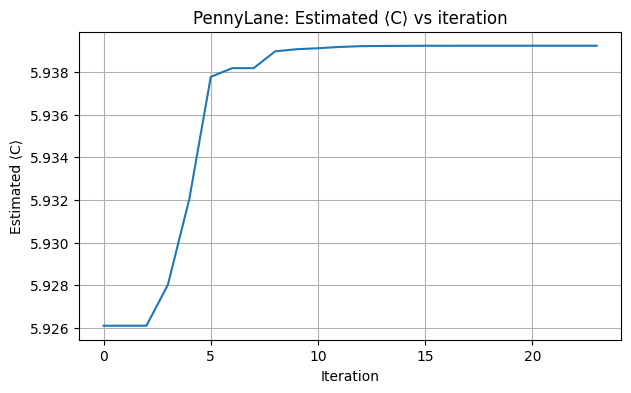

In [10]:
pl_hist = []
def pl_obj(params):
    return -expval_pl(params[:1], params[1:])
def pl_cb(xk):
    pl_hist.append(-pl_obj(xk))

x0_pl = np.random.uniform(0, math.pi, size=2)
res_pl = minimize(fun=pl_obj, x0=x0_pl, method='Nelder-Mead',
                  options={'maxiter': 80, 'disp': True, 'fatol': 1e-3},
                  callback=pl_cb)
params_pl = res_pl.x
best_exp_pl = -res_pl.fun
print("PennyLane best expected cut:", float(best_exp_pl))
print("PennyLane best params (gamma,beta):", params_pl[:1], params_pl[1:])

plt.figure()
plt.plot(pl_hist)
plt.title("PennyLane: Estimated ⟨C⟩ vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Estimated ⟨C⟩")
plt.grid(True)
plt.show()

### Sample with the optimized PennyLane parameters and show top bitstrings
We use a shot-based QNode to sample from the optimized circuit and list the most frequent outputs and their cut values.

Top 5 PennyLane sampled bitstrings (bits, count, cut):
((1, 0, 1, 0, 0, 1), 143, 7)
((0, 1, 0, 0, 1, 1), 143, 7)
((1, 0, 0, 0, 1, 1), 131, 7)
((1, 0, 1, 1, 0, 0), 129, 7)
((0, 1, 1, 1, 0, 0), 120, 7)


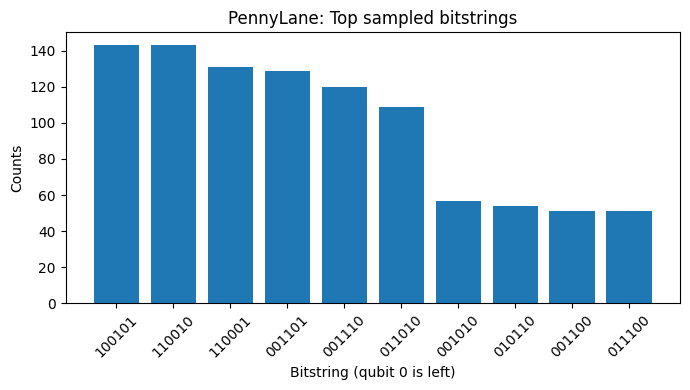

In [11]:
def pl_sample_and_top_counts(G, gammas, betas, shots=2000, top_k=10):
    n = G.number_of_nodes()
    dev_shots = qml.device('default.qubit', wires=n, shots=shots)
    @qml.qnode(dev_shots)
    def qnode_samp():
        for i in range(n):
            qml.Hadamard(wires=i)
        pl_apply_u_c(gammas[0], G)
        pl_apply_u_b(betas[0], n)
        return qml.sample(wires=range(n))
    samples = qnode_samp()
    samps = np.array(samples)
    if samps.ndim == 1:
        samps = samps.reshape((-1, n))
    counts = {}
    for r in samps:
        bits = tuple(int(x) for x in r)
        counts[bits] = counts.get(bits, 0) + 1
    items = [(bits, cnt, maxcut_value(bits, G)) for bits, cnt in counts.items()]
    return sorted(items, key=lambda x: x[1], reverse=True)

items_pl = pl_sample_and_top_counts(G, params_pl[:1], params_pl[1:], shots=2000, top_k=10)
print("Top 5 PennyLane sampled bitstrings (bits, count, cut):")
for row in items_pl[:5]:
    print(row)

labels = [''.join(map(str, b[::-1])) for b,_,_ in items_pl[:10]]
values = [cnt for _,cnt,_ in items_pl[:10]]
plt.figure()
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45)
plt.title("PennyLane: Top sampled bitstrings")
plt.xlabel("Bitstring (qubit 0 is left)")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()